# Drought Termination in CMIP6

What this notebook does:
1. Plots drought responses across multiple models
2. Plots drought indexes across multiple models
3. Identifies drought events across multiple models

## Setup

### Necessary Packages

In [215]:
# data import
import zarr
import fsspec
import intake
from dask.diagnostics import ProgressBar

# data analysis
import numpy as np
import pandas as pd
import xarray as xr
import dask 
import xesmf as xe
xr.set_options(display_style='html')
import cftime

import glob


import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

# plotting
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

import sys,os
sys.path.append("../python-utils")

### Helper Functions for Data Import

In [83]:
def get_rawdir(variable):
    if variable in os.listdir("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"):
        rawdir="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
    elif variable in os.listdir("/home/kdm2144/DROUGHT/PROCESSED/"):
        rawdir="/home/kdm2144/DROUGHT/PROCESSED/"+variable+"/"
    else:
        raise TypeError("No directory found for",variable)
    return rawdir

def get_models_old(variable):
    direc = get_rawdir(variable)
    models = sorted(os.listdir(direc))
    return models

def get_models():
    all_models = downloaded_cmip6['source_id'].unique()
    
    filtered_models = []
    
    for model in all_models:
        model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].experiment_id.unique()
        model_variables = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model)].variable_id.unique()
        
        if (set(experiments).issubset(model_experiments) & set(variables).issubset(model_variables)):
            filtered_models.append(model)
        
    return filtered_models

def get_filenames_old(model,variable,experiment,member_id):
    rawdir=get_rawdir(variable)
    return sorted(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))

def check_availability(curr_mod,curr_var,experiment_id):
    # downloaded_cmip6 is defined as a global variable rather 
    # than opening it here every single time 
    # downloaded_cmip6 = pd.read_csv("mary_cmip6.csv")
    df1 = downloaded_cmip6[(downloaded_cmip6.source_id==curr_mod)                      
                       & (downloaded_cmip6.variable_id==curr_var)                       
                       & (downloaded_cmip6.experiment_id == experiment_id)]
    return(df1)

def get_members(model):
    members = downloaded_cmip6[downloaded_cmip6['variable_id'].isin(variables) 
             & downloaded_cmip6['experiment_id'].isin(experiments)
             & downloaded_cmip6['source_id'].eq(model)].member_id.unique()
    
    filtered_members = []
    
    for member in members:
        model_experiments = downloaded_cmip6[downloaded_cmip6['source_id'].eq(model) & downloaded_cmip6['member_id'].eq(member)].experiment_id.unique()
    
        if set(experiments).issubset(model_experiments):
            filtered_members.append(member)
            
    return filtered_members

def get_members_old(model):
    members = downloaded_cmip6[downloaded_cmip6['variable_id'].isin(variables) 
             & downloaded_cmip6['experiment_id'].isin(experiments)
             & downloaded_cmip6['source_id'].eq(model)].member_id.unique()
    return members

def get_members_older(curr_mod, curr_var, experiment_id):
    """ 
    returns an array of unique member_ids for a given model, variable, and experiment
    """
    df1 = check_availability(curr_mod, curr_var, experiment_id)
    return(np.unique(df1.member_id))

def get_filenames(model, member_id):
    fnames = []
    for variable in variables:
        rawdir=get_rawdir(variable)
        for experiment in experiments:
            fnames.append(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))
    return sorted(fnames)



def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max()>180:
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def preprocess_dims(ds):
    """
    Raw Data from home/kdm2144/DROUGHT/DOWNLOADED_RAW/ has "axis_" followed by a string of numbers for the time variable. 
    This small loop renames that dimension as time to allow xarray to open and combine each year of data. 
    Adds additional information about member_id and experiment.
    """
    
    ## this should maybe include something that deals with the length? that might make the models play nicer together 
    
    for dim in ds.dims:
        if 'axis_' in dim:
            ds = ds.rename({dim: 'time'})
    
    member_id = ds.encoding['source'].split('.')[-3]
    experiment = ds.encoding['source'].split('.')[1]

    ds = fix_lon(ds)
    ds = ds.assign_coords(member_id = member_id, experiment = experiment)

    return ds

### Helper Functions for Data Analsysis

In [3]:
### GLOBAL MEANS ###

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'member_id'}
    return (ds * weight).mean(other_dims)

def region_select(ds, region_params):
    """
    subset a dataset by region
    """
    region_ds = ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']))
    return region_ds

### Data Import 


First, define some global variables, these are the experiments and variables of interest.

In [98]:
global variables 
variables = ['mrsos', 'tas', 'pr']

global experiments 
experiments = ['historical', 'ssp585'] #['historical', 'ssp126', 'ssp585']

global downloaded_cmip6
#downloaded_cmip6 = pd.read_csv("mary_cmip6.csv")
downloaded_cmip6 = pd.read_csv("dester_cmip6.csv")


global models
# call all available models
# models = get_models()

# or define a subset of models
models = ['BCC-CSM2-MR', 'ACCESS-ESM1-5']


Full models list available: 
> 'FGOALS-g3', 'CanESM5-CanOE', 'GISS-E2-1-G', 'MRI-ESM2-0', 'CESM2-WACCM', 'MIROC6', 'TaiESM1', 'FGOALS-f3-L', 'NorESM2-LM', 'GFDL-ESM4', 'ACCESS-CM2', 'MIROC-ES2L', 'KACE-1-0-G', 'CAMS-CSM1-0', 'NorESM2-MM', 'CNRM-ESM2-1', 'CNRM-CM6-1', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'CanESM5', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'HadGEM3-GC31-LL', 'EC-Earth3-Veg', 'CESM2', 'BCC-CSM2-MR', 'ACCESS-ESM1-5', 'FIO-ESM-2-0', 'GFDL-CM4', 'EC-Earth3'

Currently seeing erros in the following models and member_ids (as of October 1):
> ['FGOALS-g3', 'r1i1p1f1'], ['GISS-E2-1-G', 'r1i1p1f2'], ['GISS-E2-1-G', 'r1i1p3f1'], ['MRI-ESM2-0', 'r1i1p1f1'], ['MRI-ESM2-0', 'r1i2p1f1'], ['NorESM2-LM', 'r1i1p1f1'], ['KACE-1-0-G', 'r1i1p1f1'], ['NorESM2-MM', 'r1i1p1f1'], ['MPI-ESM1-2-LR', 'r7i1p1f1'], ['MPI-ESM1-2-LR', 'r9i1p1f1'], ['MPI-ESM1-2-LR', 'r8i1p1f1'], ['MPI-ESM1-2-LR', 'r6i1p1f1'], ['MPI-ESM1-2-LR', 'r5i1p1f1'], ['MPI-ESM1-2-LR', 'r2i1p1f1'], ['MPI-ESM1-2-LR', 'r10i1p1f1'], ['MPI-ESM1-2-LR', 'r3i1p1f1'], ['MPI-ESM1-2-LR', 'r1i1p1f1'], ['MPI-ESM1-2-LR', 'r4i1p1f1'], ['CanESM5', 'r8i1p2f1'], ['CanESM5', 'r4i1p2f1'], ['CanESM5', 'r2i1p2f1'], ['CanESM5', 'r6i1p2f1'], ['CanESM5', 'r7i1p2f1'], ['CanESM5', 'r9i1p2f1'], ['CanESM5', 'r6i1p1f1'], ['CanESM5', 'r3i1p2f1'], ['CanESM5', 'r5i1p2f1'], ['EC-Earth3-Veg', 'r3i1p1f1']

Error text: "MergeError: conflicting values for variable 'experiment' on objects to be combined. You can skip this check by specifying compat='override'."

### Lazily load models and member ids into a dictionary of dictionaries

In [99]:
ddict = {model : {} for model in models}

# apparently this made it duplicate everything?@?@ so fun, wtf python
# ddict = dict.fromkeys(models, {})

errors = []

for model in tqdm(ddict.keys()):
    print("starting " + model)
    member_ids = get_members(model)
    print(member_ids)
    for member_id in member_ids:
        fnames = get_filenames(model, member_id)
        print("     acquired " + member_id + "'s filename")
        try: 
            ddict[model][member_id] = xr.open_mfdataset(fnames, parallel = True, 
                                                        preprocess = preprocess_dims, 
                                                        drop_variables=['lon_bnds', 'lat_bnds'])
        except:
            errors.append([model, member_id])
            print("*** ERROR ***  " + model + " : " + member_id)


  0%|          | 0/2 [00:00<?, ?it/s]

starting BCC-CSM2-MR
['r1i1p1f1']
     acquired r1i1p1f1's filename
starting ACCESS-ESM1-5
['r2i1p1f1', 'r1i1p1f1', 'r3i1p1f1']
     acquired r2i1p1f1's filename
     acquired r1i1p1f1's filename
     acquired r3i1p1f1's filename


## Spatial responses over select region 

I'm using 1861-1880 for the base period (decent temperature record coverage, GHGs almost at preindustrial, no annoying volcanoes).

In [86]:
# define region
region_params = {'lat':[25,55],'lon':[-15, 45]}

In [87]:
def responses(ds):
    """
    Calculate difference between early and late period.
    Lazy.
    """

    ds = ds.copy()
    
    early_start = '1861'
    early_end = '1880'
    early = ds.sel(time=slice(early_start, early_end)).mean(dim = 'time')
    
    late_start = '2050'
    late_end = '2100'
    late = ds.sel(time = slice(late_start, late_end)).mean(dim = 'time')
    
    difference = (late - early)/early.std()
    
    return difference

In [107]:
model_responses = {model : {} for model in models}

for model in tqdm(model_responses.keys()):
    print('starting ' + model)
    for member_id in ddict[model].keys():
        model_responses[model][member_id] = responses(region_select(ddict[model][member_id], region_params)).load()

  0%|          | 0/2 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting ACCESS-ESM1-5


CPU times: user 54.5 ms, sys: 7.81 ms, total: 62.3 ms
Wall time: 59.5 ms


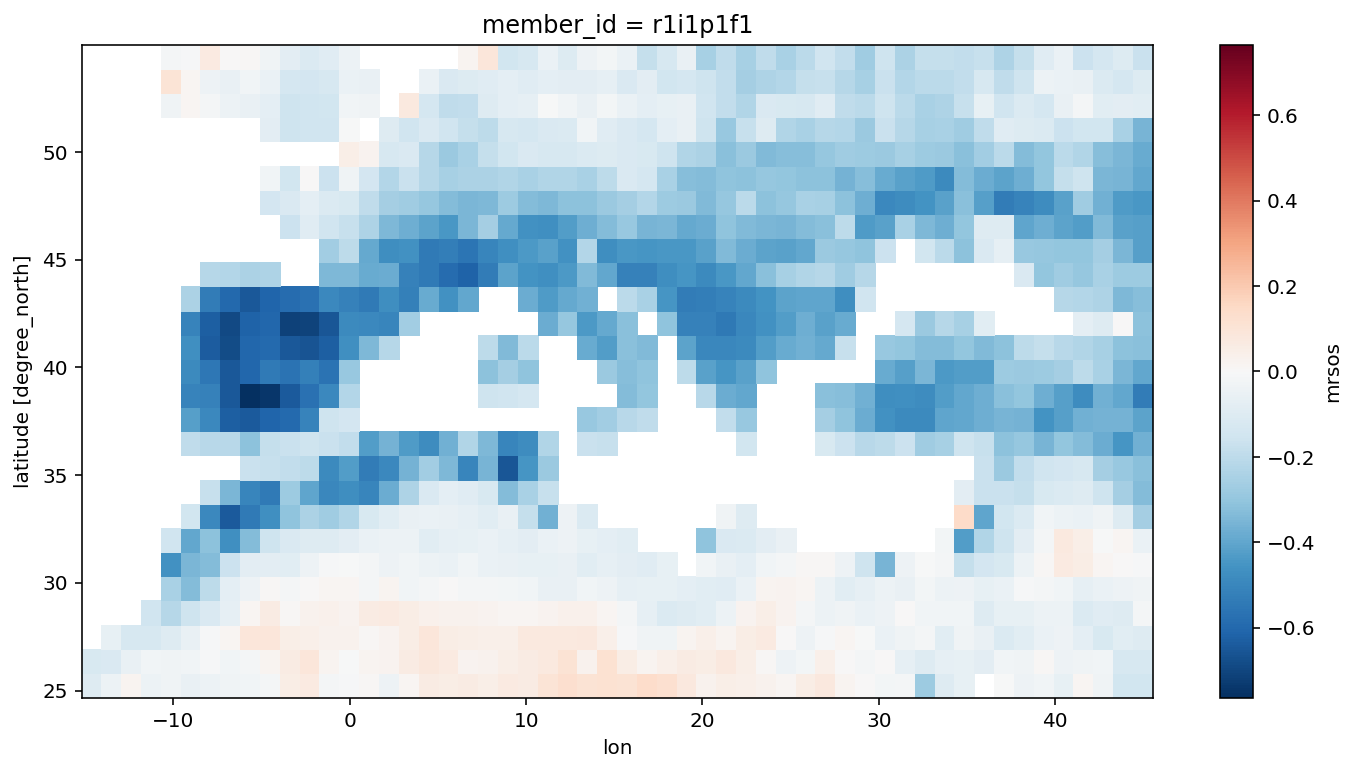

In [108]:
%time model_responses['BCC-CSM2-MR']['r1i1p1f1'].mrsos.plot()

Calculates the ensemble average before plotting

In [179]:
ensemble_responses = {model : {} for model in models}

for model, members in model_responses.items():
    ensemble_responses[model] = (sum(members.values())/len(members.items())).drop_vars('member_id')
    
    

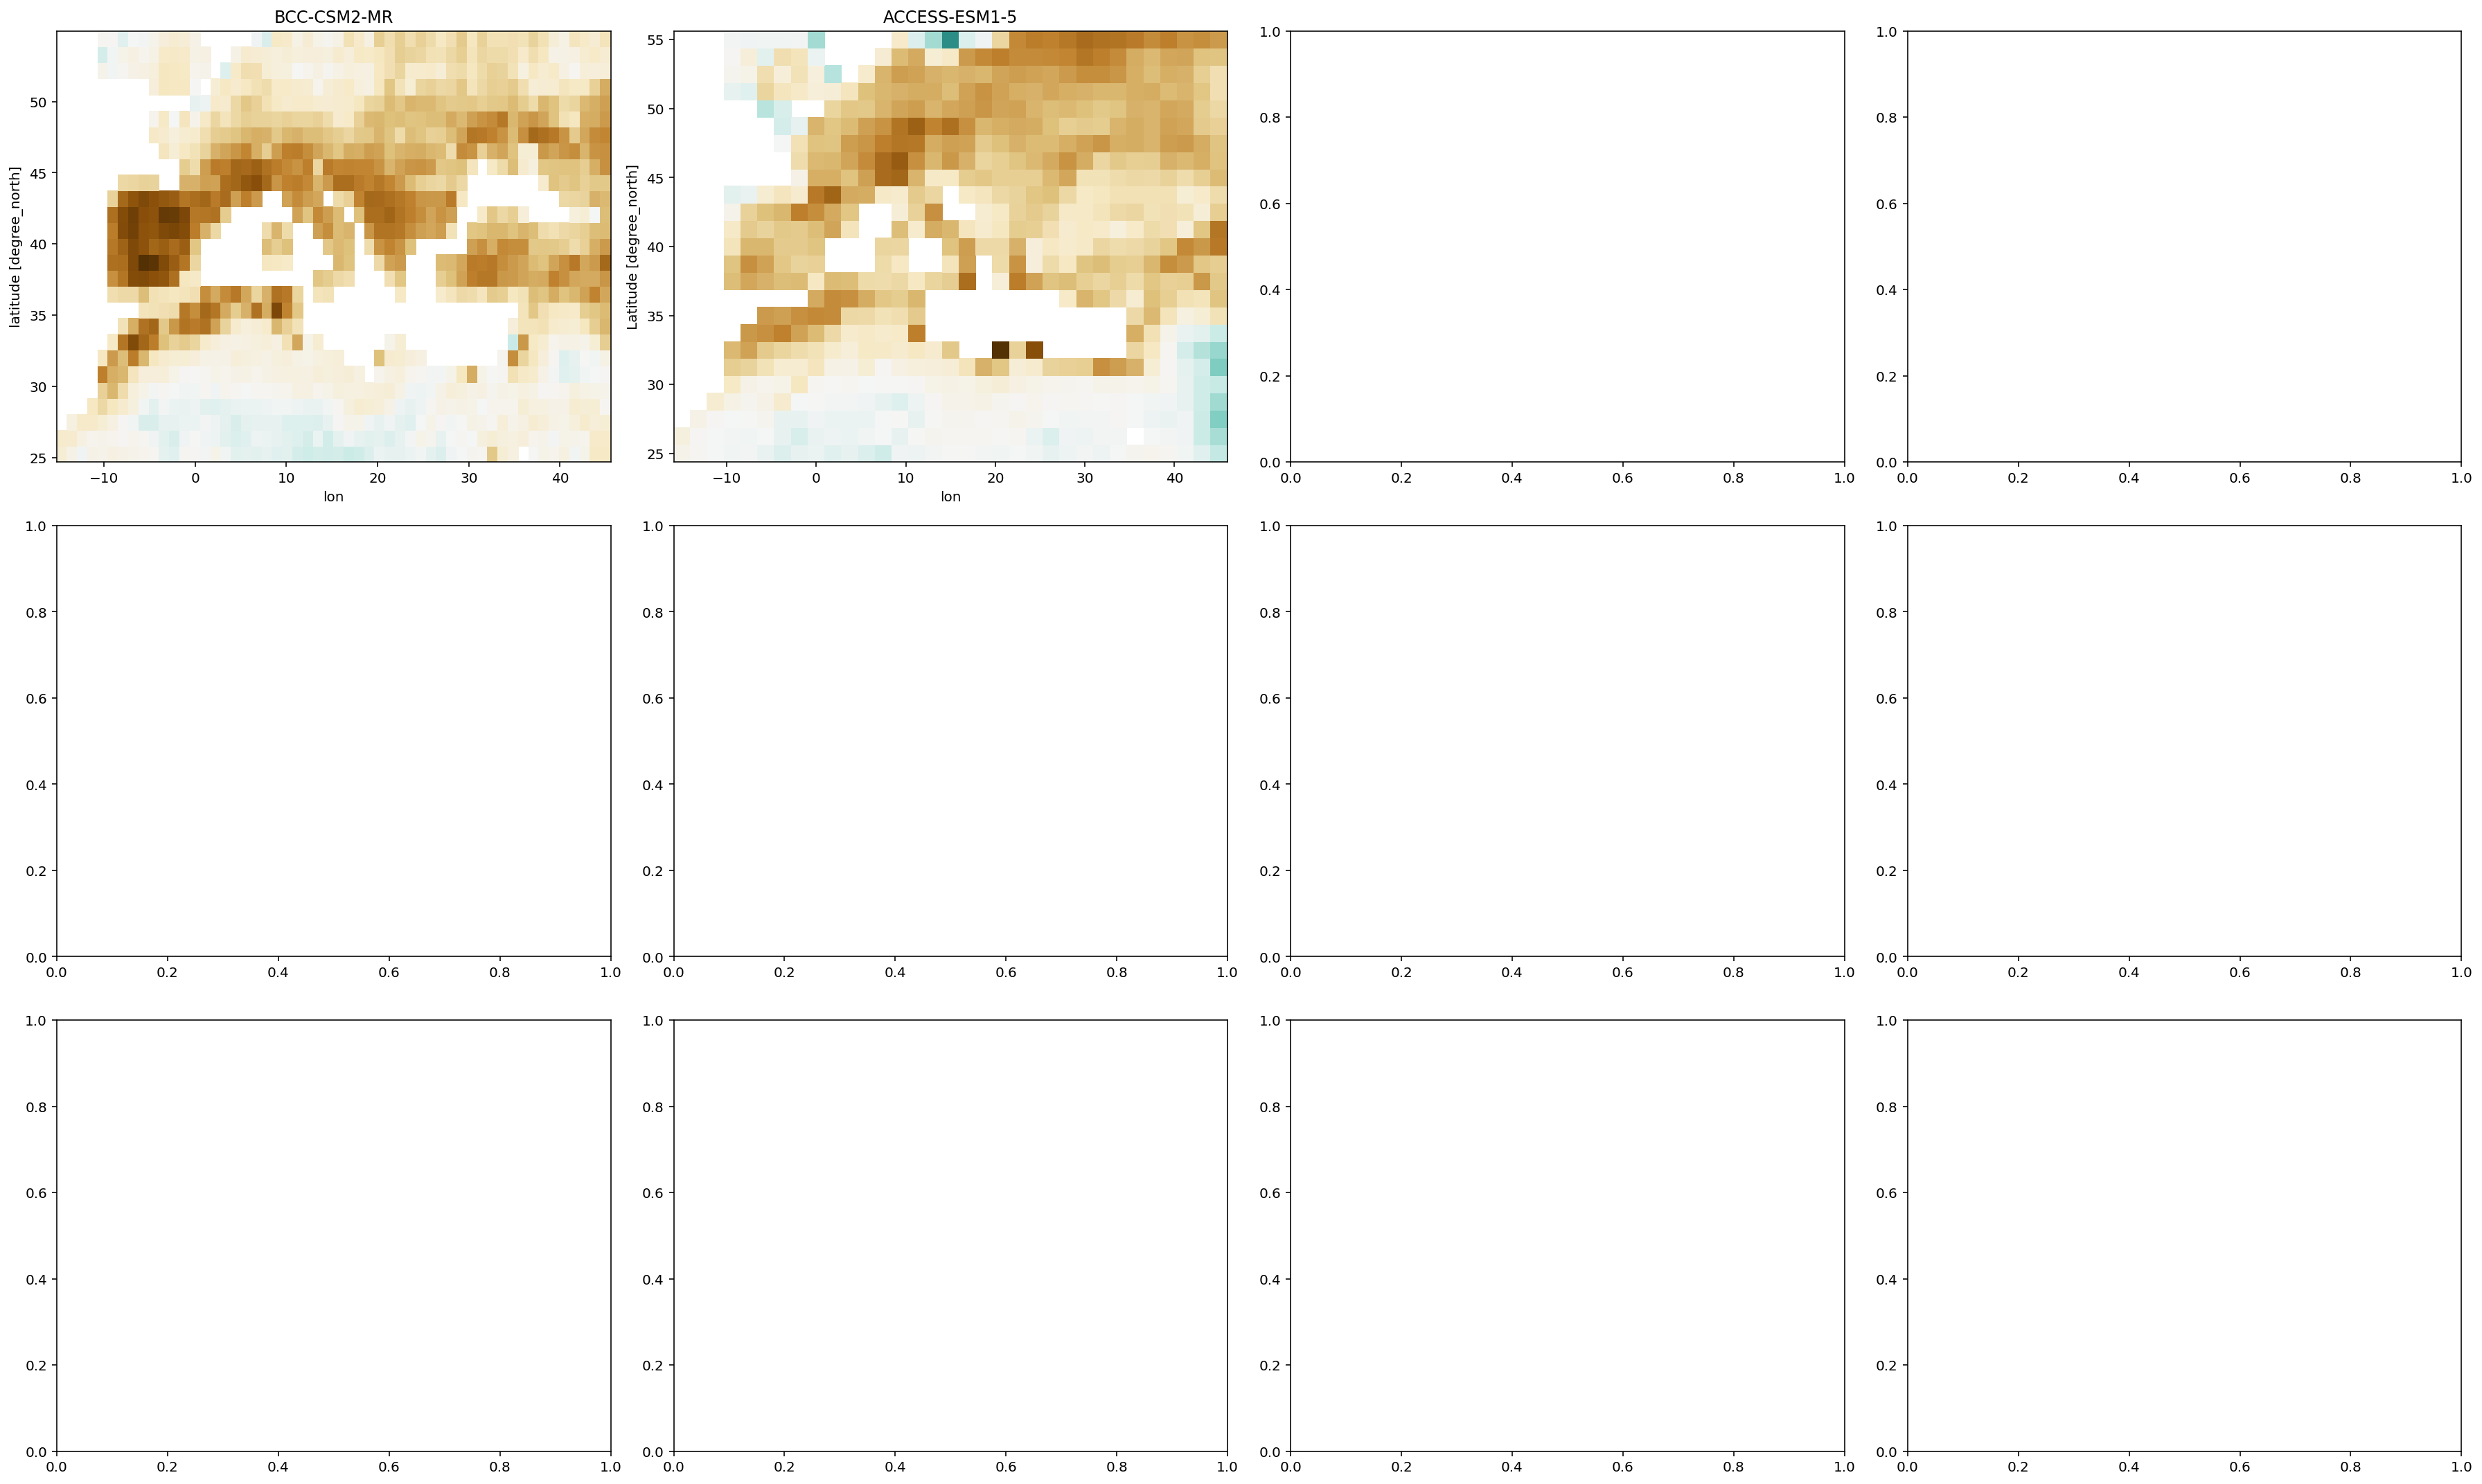

In [220]:
nrows = 3
ncols = 4

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [25, 15]) #, subplot_kw={"projection": ccrs.Robinson()})

for ax, model in zip(axarr.flat, ensemble_responses.keys()):
    sms = ensemble_responses[model].mrsos.plot(cmap = 'BrBG', ax = ax, add_colorbar = False) # transform=ccrs.PlateCarree()
    
    #gl = ax.gridlines(draw_labels=True, dms=True, 
    #             x_inline=False, y_inline=False, 
    #             zorder = 3)

    #gl.top_labels = False
    #gl.right_labels = False

    #ax.add_feature(cfeature.OCEAN, zorder = 2, facecolor = '0.9')
    #ax.coastlines(zorder = 3)
    ax.set_title(model) #, y = 1.15)
    
### [left/right, up/down, , size]    
#cbar_ax_sms = fig.add_axes([0.92, 0.67, 0.015, 0.2])
#cbar_ax_sms = fig.add_axes([0.92, 0.3, 0.015, 0.5])
#fig.colorbar(sms, cax = cbar_ax_sms, label = 'Surface Soil Moisture')

plt.tight_layout()

## Drought Index 

The below code block loads the data into memory, this can take a while

In [116]:
model_anoms = {model : {} for model in models}

for model in tqdm(model_anoms.keys()):
    print('starting ' + model)
    for member_id in ddict[model].keys():
        ds = region_select(ddict[model][member_id], region_params).load()
        
        # flagging for baseline sensitivity test
        baseline = ds.sel(time = slice('1861', '1880')).groupby('time.month')
        ds_standard = (ds.groupby('time.month') - baseline.mean())/baseline.std()
        ds_anom = global_mean(ds_standard)
        model_anoms[model][member_id] = ds_anom
            

  0%|          | 0/2 [00:00<?, ?it/s]

starting BCC-CSM2-MR
starting ACCESS-ESM1-5


## Drought Detection

In [137]:
## 3 month Rolling Mean
model_anoms_r = {model : {} for model in models}

for model in tqdm(model_anoms_r.keys()):
    print('starting' + model)
    for member_id in model_anoms[model].keys():
        model_anoms_r[model][member_id] = model_anoms[model][member_id].rolling(time = 3, center = False).mean()

        # Creating a Mask/for 3 month drought means

        point5_sd = model_anoms_r[model][member_id].mrsos <= -0.5
        #point5_sd = model_anoms_r[model][member_id] <= -0.5

        point5_sd_mask = point5_sd.to_masked_array()
        point5_sd_mask.mask = ~point5_sd
        point5_sd_trues = np.ma.notmasked_contiguous(point5_sd_mask)

        for slices in point5_sd_trues:
            # can change number of slices start to make more or less sensitive
            if (slices.stop - slices.start < 3):
                #point5_sd[slices].values = False
                point5_sd[slices] = False

        one_sd = model_anoms_r[model][member_id].mrsos <= -1
        #one_sd = model_anoms_r[model][member_id] <= -1

        one_sd_mask = one_sd.to_masked_array()
        one_sd_mask.mask = ~one_sd
        one_sd_trues = np.ma.notmasked_contiguous(one_sd_mask)

        for slices in one_sd_trues:
            # can change number of slices start to make more or less sensitive
            if (slices.stop - slices.start < 3):
                #one_sd[slices].values = False
                one_sd[slices] = False

        model_anoms_r[model][member_id]['point5_sd'] = point5_sd
        model_anoms_r[model][member_id]['one_sd'] = one_sd

  0%|          | 0/2 [00:00<?, ?it/s]

startingBCC-CSM2-MR
startingACCESS-ESM1-5


PLOT ONE MODEL WITH PRECIP AS AN EXAMPLE: 

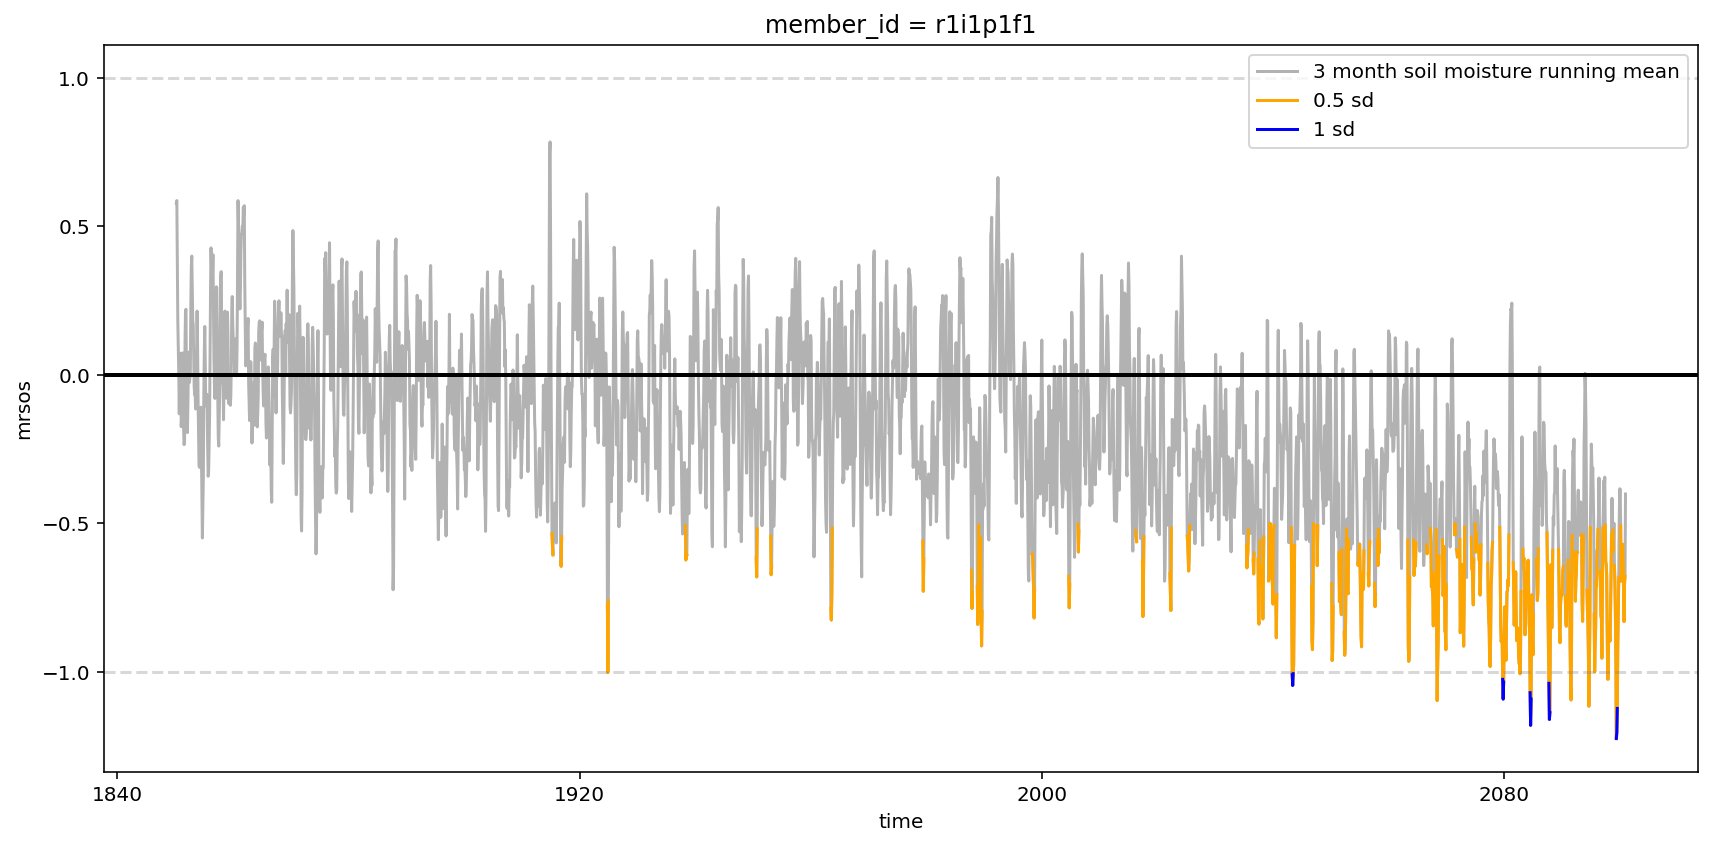

In [140]:
model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].mrsos.plot(color = 'k', alpha = 0.3, label = '3 month soil moisture running mean')


model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].where(model_anoms_r['BCC-CSM2-MR']['r1i1p1f1']['point5_sd']).mrsos.plot(color = 'orange', label = '0.5 sd')
model_anoms_r['BCC-CSM2-MR']['r1i1p1f1'].where(model_anoms_r['BCC-CSM2-MR']['r1i1p1f1']['one_sd']).mrsos.plot(color = 'blue', label = "1 sd")


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)
    
plt.legend()

plt.tight_layout()

PLOT MULTIPLE ENSEMBLE MEMBERS (IDEALLY WITH PRECIP)

In [224]:
fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [20, 10])

for ax, model in zip(axarr.flat, model_anoms.keys()):
    for ax, member_id in zip(axarr.flat, model_anoms_r[model].keys()):
        
        #model_anoms_r[model][member_id].mrsos.plot(color = 'k', alpha = 0.3, label = '3 month soil moisture running mean', ax = ax)
    


SyntaxError: unexpected EOF while parsing (<ipython-input-224-08197a5891fa>, line 6)

In [143]:

nrows = 2
ncols = 3

fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [20, 10])

for ax, model in zip(axarr.flat, model_anoms.keys()):

    for ax, member_id in zip(axarr.flat, model_anoms_r[model].keys()):
        model_anoms_r[model][member_id].mrsos.plot(color = 'k', alpha = 0.3, label = '3 month soil moisture running mean', ax = ax)


        model_anoms_r[model][member_id].where(model_anoms_r[model][member_id]['point5_sd']).mrsos.plot(color = 'orange', label = '0.5 sd', ax = ax)
        model_anoms_r[model][member_id].where(model_anoms_r[model][member_id]['one_sd']).mrsos.plot(color = 'blue', label = "1 sd", ax = ax)


        # 0 Line
        ax.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
        ax.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
        ax.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)

plt.legend()
plt.suptitle('BCC-CSM2-MR | Region: Mediterranean ')
plt.tight_layout()


TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

the mary csv doesn't match up with the files available in the raw data file on dester, so I had to drop a few 

In [ ]:
get_members('ACCESS-ESM1-5')

In [ ]:
ddict_test['ACCESS-ESM1-5'].keys()

In [ ]:
r13 = xr.open_mfdataset(get_filenames('ACCESS-ESM1-5','r13i1p1f1'), preprocess = preprocess_dims)

In [ ]:
downloaded_cmip6[(downloaded_cmip6.member_id == 'r13i1p1f1') & (downloaded_cmip6.source_id == 'ACCESS-ESM1-5')]

In [ ]:
get_filenames('ACCESS-ESM1-5','r13i1p1f1')

In [ ]:
model = "ACCESS-CM2"

member_ids = get_members(model)
for member_id in member_ids:
    fnames = get_filenames(model, member_id)
    ddict_test[model][member_id] = xr.open_mfdataset(fnames, preprocess = preprocess_dims)

             __.-/|
             \`o_O'
              =( )=  +------------------+
                U|   | here be dragons  |
      /\  /\   / |   +------------------+
     ) /^\) ^\/ _)\     |
     )   /^\/   _) \    |
     )   _ /  / _)  \___|_
 /\  )/\/ ||  | )_)\___,|))
<  >      |(,,) )__)    |
 ||      /    \)___)\
 | \____(      )___) )____
  \______(_______;;;)__;;;)

In [ ]:
variable = 'tas'
experiment = 'historical'

ddict_test = dict.fromkeys(models, {})
for model in ddict_test.keys():
    member_ids = get_members(model, variable)
    print(member_ids)


In [ ]:
ddict_mrsos = model_import(models, 'mrsos', experiments)

In [ ]:
ddict_pr = model_import(models, 'pr', experiments)

In [ ]:
ddict_tas = model_import(models, 'tas', experiments)

In [ ]:
# testing out that it worked
global_mean(ddict_mrsos['CAMS-CSM1-0'].mean(dim = 'member_id').mrsos).plot()

In [ ]:
ddict_tas['CAMS-CSM1-0']

In [ ]:
ddict_mrsos['CAMS-CSM1-0']

In [ ]:
xr.merge([ddict_mrsos['CAMS-CSM1-0'], ddict_tas['CAMS-CSM1-0']], compat = 'override')

In [ ]:
ddict_concat = {}

for model in tqdm(models):
    print('starting ' + model)

    ddict_concat[model] = xr.merge([ddict_mrsos[model], ddict_tas[model], ddict_pr[model]])

In [ ]:
def model_import_old(models, variable, experiments):
    ddict = {}
    for model in tqdm(models):
        print('starting ' + model)
        tmp = []
        for experiment in experiments:
            fname = []
            member_ids = get_members(model, variable, experiment)
            for member in member_ids:
                fname.append(get_filenames(model, variable, experiment, member))
            tmp.append(xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                                     preprocess = preprocess_dims))

        ddict[model] = xr.concat(tmp, dim = 'member_id')
    return ddict

In [ ]:
#def get_filenames(model, member_id):
#    fnames = []
#    for variable in variables:
#        rawdir=get_rawdir(variable)
#        for experiment in experiments:
#            fnames.append(glob.glob(rawdir+model+"/*."+experiment+".*"+member_id+".*"))
#    return sorted(fnames)

In [ ]:
def make_dataframe():
    #allvariables=['tas', 'mrro', 'mrros', 'mrso', "mrsos",'pr', 'evspsbl', 'prsn']
    #experiments=["piControl","historical","ssp126","ssp585","ssp370","ssp245"]
    
    #allvariables = ['mrsos', 'tas', 'pr']
    #experiments = ['historical', 'ssp126', 'ssp585']
    d={}
    d["filename"]=[]
    d["model"]=[]
    d["variable"]=[]
    d["member_id"]=[]
    d["experiment"]=[]

    for variable in variables:
        direc = get_rawdir(variable)
        models=sorted(os.listdir(direc))

        for model in models:
            for experiment in experiments:
                filenames=glob.glob(direc+model+"/*."+experiment+".*")
                for fname in filenames:
                    d["filename"]+=[fname]
                    d["model"]+=[model]
                    d["variable"]+=[variable]
                    d["member_id"]+=[fname.split(".")[3]]
                    d["experiment"]+=[experiment]
    df=pd.DataFrame(d)
    return df

In [ ]:
df = make_dataframe()

In [ ]:
df

In [ ]:
# make arrays of models and member_ids for later use
models = df.model.unique()
member_ids = df.member_id.unique()

In [ ]:
# make a dictionary to hold all the data for easy iteration and plotting
dset_dict = {}
for model in models:
    dset_dict[model] = {}
    #for variable in variables:
    #    dset_dict[model] 

In [ ]:
#experiment = ["historical", 'ssp585']
variable = "mrsos"
model = "ACCESS-CM2"

rawdir = "/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"

In [ ]:
#member = "r1i1p1f1"

In [ ]:
#glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+ member + "*")

In [ ]:
tmp = {}

for experiment in tqdm(experiments):
    #for model in models:
    member_ids = get_members(model, variable, experiment)
    for member in member_ids:
        tmp[member] = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.'+ member + '*'), 
                                        preprocess = fix_dims).assign_coords(member_id = member, experiment = experiment) 

In [ ]:
fname = []


for experiment in tqdm(experiments):
    #for model in models:

member_ids = get_members(model, variable, experiment)
for member in member_ids:
    fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))
    
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [ ]:
variables = ['mrsos', 'pr', 'tas']
experiments = ['historical', 'ssp585']
models = ['ACCESS-CM2', 'CanESM5']

fname = []
#for variable in variables:
for experiment in experiments:
    member_ids = get_members(model, variable, experiment)
    for member in member_ids:
        fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))

boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['experiment', 'member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [ ]:

boop = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '*'),  
                         preprocess = preprocess_dims)

In [ ]:
ds = xr.open_mfdataset(rawdir + 'ACCESS-CM2/mrsos.historical.ACCESS-CM2.r1i1p1f1.1850.nc', preprocess = preprocess_dims)

In [ ]:
ds

In [ ]:
tmp['r1i1p1f1']


In [ ]:
test = xr.combine_nested([tmp['r1i1p1f1'],tmp['r2i1p1f1']], concat_dim = 'time')

In [ ]:
test.mrsos

test.member_

In [ ]:
#tmp.load()

In [ ]:
#global_mean(tmp).mrsos.plot()

In [ ]:
test = {}

for experiment in tqdm(experiments):
    print(experiment)
    for variable in variables:
        print(variable)
        #rawdir = get_rawdir(variable)
        rawdir = "/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
            #for model in models:
            member_ids = get_members(model, variable, experiment)
            #print(model + ":" + member_ids)
            for member in member_ids:
                test[member] = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + member + '*'), preprocess = fix_dims)
                #test = xr.open_mfdataset(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+member+".*"), preprocess = fix_dims)



In [ ]:
xr.open_mfdataset

In [ ]:
#things are opening properly, but now need to make sure models and ensemble members stay seperated 

In [ ]:
test = xr.open_mfdataset(df.filename[0:10], preprocess = fix_dims, combine="by_coords")

In [ ]:
test.mrsos

In [ ]:
model_dict = {}

In [ ]:
model = "ACCESS-CM2"
member = "r1i1p1f1"
experiment = "historical"

fname = []

member_ids = get_members(model, variable, experiment)
for member in member_ids:
    fname.append(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.' + member + '*'))
    
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [ ]:
boop = xr.open_mfdataset(fname, combine = 'nested', concat_dim = ['member_id', 'time'],  
                         preprocess = fix_dims).assign_coords(member_id = member_ids)

In [ ]:
#fname

In [ ]:
boop

In [ ]:
boop

In [ ]:
model = "ACCESS-CM2"
member = "r1i1p1f1"
experiment = "historical"

boop = xr.open_mfdataset(glob.glob(rawdir+model+'/' + variable +'.'+ experiment + '.' + model + '.*'), preprocess = fix_dims)

In [ ]:
model = "ACCESS-CM2"
experiment = "historical"
variable = "mrsos"

member_ids = get_members(model, variable, experiment)


In [ ]:
member_ids

In [ ]:
xr.open_dataset(rawdir + '/ACCESS-CM2/mrsos.historical.ACCESS-CM2.r1i1p1f1.1863.nc')